# Moving Least Squares Demo

This notebook will demonstrate the features of the Entropic Trajectories framework with respect to 
estimating derivatives of 1d and 2d functions.  We begin by importing the required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# we'll need Matrix, UGrid, and Approximator
from etraj.etraj import Vector, Matrix, UGrid, Approximator, ScalarField
import etraj.etraj as et

In [2]:
# create a random one-dimensional grid
# between -pi and pi.
N = 10000
x = np.random.uniform(-np.pi,np.pi,N)

g = UGrid(x)

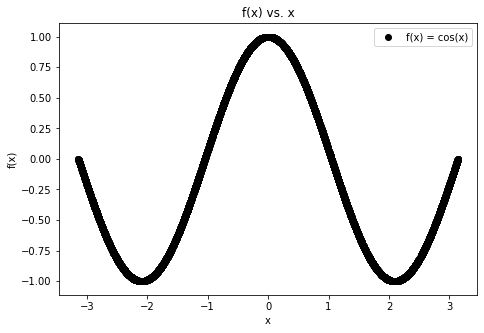

In [3]:
# generate the function values for f(x) = cos(x)
f = np.cos(1.5*x)
# plot the result
fig, axs = plt.subplots(figsize=(7.5,5))
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

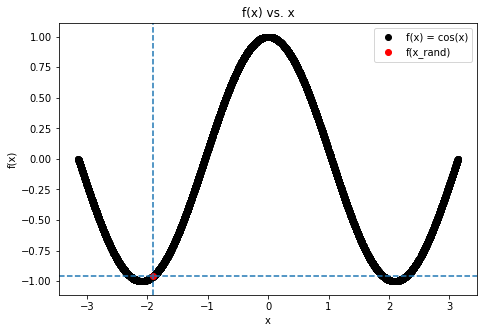

In [4]:
# consider a random point in our grid
i_rand = np.random.randint(len(x))
x_rand, f_rand = x[i_rand], f[i_rand]
# lets plot that point
fig, axs = plt.subplots(figsize=(7.5,5))
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)')
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

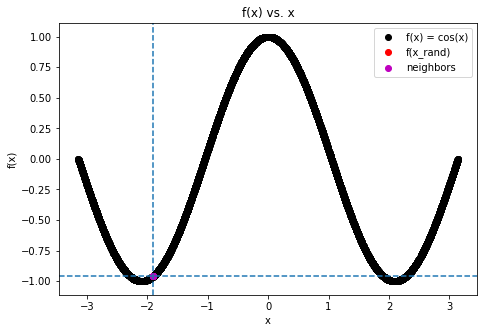

In [5]:
# select a number of nearest neighbors to use for the point
k = 6
g.query_neighbors(k)
# grab the nearest neighbors to the point x_rand
neighbors = g.get_neighbors(i_rand)
x_neighbors = [x[i] for i in neighbors]
f_neighbors = [f[i] for i in neighbors]
# plot the result
fig, axs = plt.subplots(figsize=(7.5,5))
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)')
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors')
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

In [6]:
# let's use those neighbors to approximate the derivative
# of f(x) at x_rand.
app = Approximator()
# construct the B matrix for first order in the Taylor expansion
b_matrix = app.construct_taylor_matrix(g,neighbors,i_rand,3)
print(b_matrix)

dim: (6x4), type: double&, name: 'B'
[  1.000e+00   0.000e+00   0.000e+00   0.000e+00
   1.000e+00   1.213e-04   1.471e-08   1.785e-12
   1.000e+00   4.122e-04   1.699e-07   7.003e-11
   1.000e+00   8.439e-04   7.121e-07   6.009e-10
   1.000e+00   9.168e-04   8.406e-07   7.707e-10
   1.000e+00  -9.593e-04   9.203e-07  -8.828e-10  ]


In [7]:
# solve the least squares problem Ax = y
# where y is the f_neighbors
# and x are the coefficients
v = Vector(f_neighbors)
f_app = et.dgelsd(b_matrix,v)
print(f_app)

dim: 4, type: double&
[ -9.600e-01   4.202e-01   1.080e+00  -1.577e-01  ]


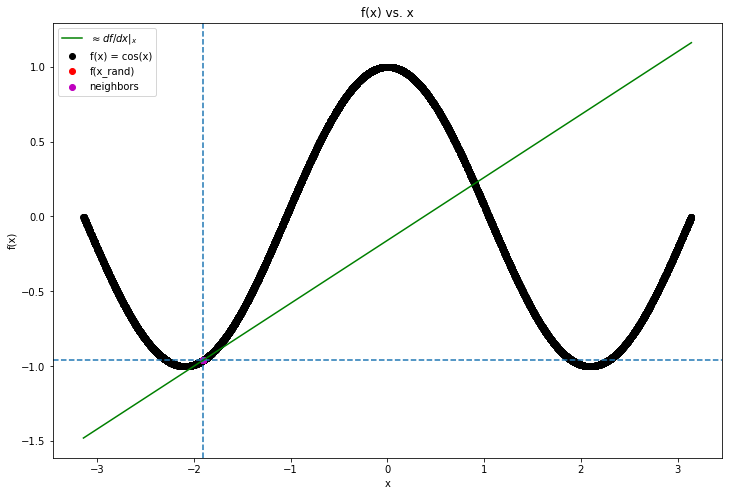

In [8]:
# the first factor is the derivative of f_rand at
# x_rand.
f_0 = -f_app[1]*x_rand + f_app[0]
f_d = f_app[1]
x_lin = np.linspace(-np.pi,np.pi,50)
tangent = f_d*x_lin + f_0
fig, axs = plt.subplots(figsize=(12,8))
axs.scatter(x,f,color='k',label='f(x) = cos(x)')
axs.scatter(x_rand,f_rand,color='r',label='f(x_rand)')
axs.scatter(x_neighbors,f_neighbors,color='m',label='neighbors')
axs.axhline(f_rand,linestyle='--')
axs.axvline(x_rand,linestyle='--')
axs.plot(x_lin,tangent,color='g',label=r'$\approx df/dx|_{x}$')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

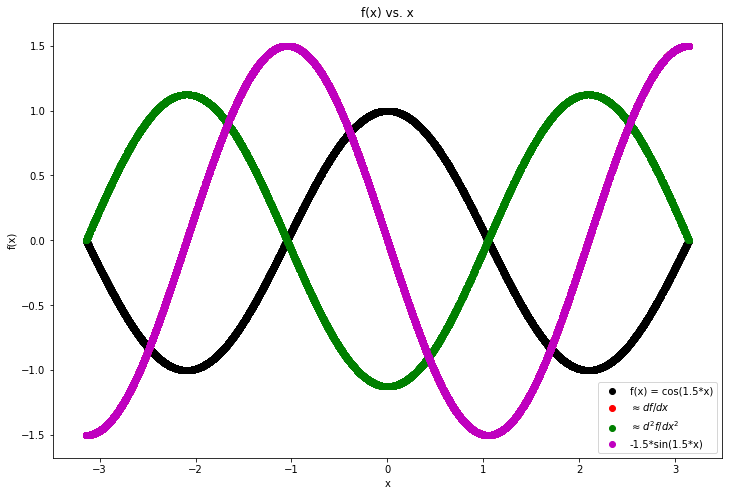

In [9]:
# let's approximate the first and second derivative of the entire function
k = 3
g.query_neighbors(k)
f_der = []
f_derr = []
f_der_true = -1.5*np.sin(1.5*x)
for i in range(len(x)):
    temp_neighbors = g.get_neighbors(i)
    b_matrix = app.construct_taylor_matrix(g,temp_neighbors,i,5)
    x_neighbors = [x[m] for m in temp_neighbors]
    f_neighbors = [f[m] for m in temp_neighbors]
    v = Vector(f_neighbors)
    f_app = et.dgels(b_matrix,v)
    f_der.append(f_app[1])
    f_derr.append(f_app[2])
fig, axs = plt.subplots(figsize=(12,8))
axs.scatter(x,f,color='k',label='f(x) = cos(1.5*x)')
axs.scatter(x,f_der,color='r',label=r'$\approx df/dx$')
axs.scatter(x,f_derr,color='g',label=r'$\approx d^2f/dx^2$')
axs.scatter(x,f_der_true,color='m',label='-1.5*sin(1.5*x)')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

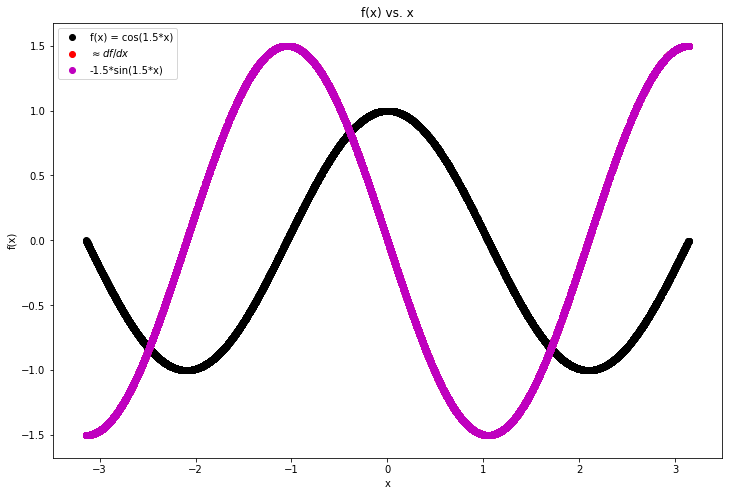

In [10]:
# Computing the gradient of f(x) can be done in a much 
# more compact way by calling ScalarFields gradient function
sfield = ScalarField(g,f,g.get_logger())
grad_sfield = sfield.gradient()
f_der2 = [grad_sfield[i][0] for i in range(len(grad_sfield))]
fig, axs = plt.subplots(figsize=(12,8))
axs.scatter(x,f,color='k',label='f(x) = cos(1.5*x)')
axs.scatter(x,f_der2,color='r',label=r'$\approx df/dx$')
axs.scatter(x,f_der_true,color='m',label='-1.5*sin(1.5*x)')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()

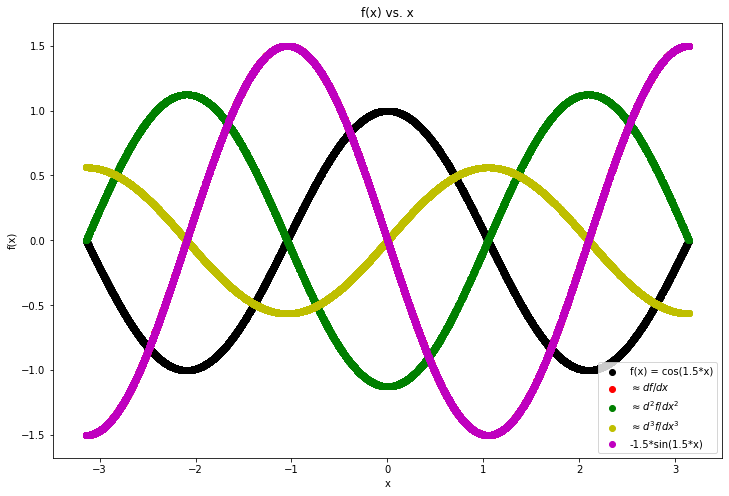

In [15]:
# an even more compact way is to use the derivative function
k = 6
sfield.get_approximator().set_k(k)
sfield.get_approximator().set_lsdriver("xGELSS")
der_sfield = sfield.derivative(0,1)
der2_sfield = sfield.derivative(0,2)
der3_sfield = sfield.derivative(0,3)
fig, axs = plt.subplots(figsize=(12,8))
axs.scatter(x,f,color='k',label='f(x) = cos(1.5*x)')
axs.scatter(x,der_sfield,color='r',label=r'$\approx df/dx$')
axs.scatter(x,der2_sfield,color='g',label=r'$\approx d^2f/dx^2$')
axs.scatter(x,der3_sfield,color='y',label=r'$\approx d^3f/dx^3$')
axs.scatter(x,f_der_true,color='m',label='-1.5*sin(1.5*x)')
axs.set_xlabel("x")
axs.set_ylabel("f(x)")
axs.set_title("f(x) vs. x")
plt.legend()
plt.show()